In [7]:
import pandas as pd
import scipy as sp
import daft

import matplotlib.pyplot as plt
import numpy as np

from abtools import ABtest, BernoulliModel

%matplotlib inline

In [8]:
p = .05
size = 200000
delta_true = .025

a = sp.stats.bernoulli.rvs(p=p, size=size, random_state=8228)
b = sp.stats.bernoulli.rvs(p=p*(1+delta_true), size=size, random_state=8228)

print('A - Mean: %.4f, std: %.2f' % (a.mean(), a.std()))
print('B - Mean: %.4f, std: %.2f' % (b.mean(), b.std()))
print('B better A on %.4f = %.4f%%' % (b.mean()- a.mean(), (b.mean()/a.mean()-1)*100))

A - Mean: 0.0502, std: 0.22
B - Mean: 0.0513, std: 0.22
B better A on 0.0011 = 2.2917%


In [9]:
test = ABtest(BernoulliModel, [a, b], 5000)

test.estimate()

ABtest for 2 groups


In [10]:
test.probabilities_df

,group1,group2,mean
group1,-,0.9526,0.0501858597334
group2,0.0474,-,0.0513366614923
mean,0.0501858597334,0.0513366614923,-


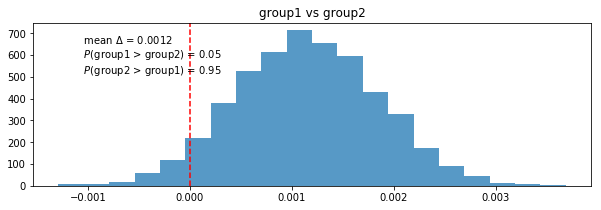

In [11]:
test.plot()